# 2. Traditional ML models, trained with new features.

Retraining ML model using 6 features from Staley model (those available from USGS shapefiles) 

- I15, total accumulation, storm duration, Area, PropHM23, dNBR1000, KF

and three new features:

- fraction of unconsolidated and sedimentary rocks (`SedUn`)
- fraction of susceptible vegetation types (`SuscFrac`)
- Fine fuel load



In [90]:
import pandas as pd
pd.set_option("max_colwidth", 50)
import pickle
import numpy as np

In [91]:
trainX, trainY, testX, testY = pickle.load(open("staley16+addtl_feats_split.pkl","rb"))

In [92]:
trainX.columns

Index(['stormdur_h', 'stormaccum_mm', 'peak_i15_mmh', 'contributingarea_km2',
       'prophm23', 'dnbr1000', 'kf', 'SedUn', 'SuscFrac', 'Fine fuel load'],
      dtype='object')

Reduce to features from Staley's model only:

If `Fine fuel load` is not in the dataframe, rerun the [feature preparation](Feat_prep_and_split.ipynb) notebook, as it has changed.

In [93]:
use_feats = trainX.columns

In [94]:
trainX.shape, testX.shape, trainY.shape, testY.shape

((984, 10), (257, 10), (984,), (257,))

In [95]:
#pd.concat([trainX, testX]).describe()

In [96]:
from sklearn.neighbors import KNeighborsClassifier, DistanceMetric
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

Function to get score for given classifier, and save into dataframe:

In [97]:
def get_scores(trues, probs):
    scores=[func(trues, np.round(probs[:,1])) for func in [accuracy_score, jaccard_score, f1_score]]
    scores.append(roc_auc_score(trues, probs[:,1]))
    return scores

def get_scoredf(TrTr, TrPr, TeTr, TePr):
    train_scores=get_scores(TrTr, TrPr)
    test_scores=get_scores(TeTr, TePr)
    
    scoredf=pd.DataFrame({"Training": train_scores, "Test": test_scores}, 
                         index=["Accurary", "Jaccard", "F1", "AUC"])
    return scoredf

In [98]:
select_criterion="entropy"
clfp=DecisionTreeClassifier(criterion=select_criterion, max_depth=8)

clfp.fit(trainX, trainY)
trainYp=clfp.predict_proba(trainX)
testYp=clfp.predict_proba(testX)

scoredf_dt=get_scoredf(trainY, trainYp, testY, testYp)
scoredf_dt

,Training,Test
Accurary,0.907520,0.836576
Jaccard,0.682927,0.454545
F1,0.811594,0.625000
AUC,0.974912,0.834000


Testing different ML models:

In [99]:
clfl = LogisticRegression(random_state=0, max_iter=10000).fit(trainX, trainY)
trainYp=clfl.predict_proba(trainX)
testYp=clfl.predict_proba(testX)

scoredf_lr=get_scoredf(trainY, trainYp, testY, testYp)
scoredf_lr

,Training,Test
Accurary,0.792683,0.840467
Jaccard,0.346154,0.405797
F1,0.514286,0.577320
AUC,0.839333,0.858475


In [100]:
rfdpt=20
clff = RandomForestClassifier(max_depth=rfdpt, random_state=0, criterion="entropy")

clff.fit(trainX, trainY)
trainYp=clff.predict_proba(trainX)
testYp=clff.predict_proba(testX)

scoredf_rf=get_scoredf(trainY, trainYp, testY, testYp)
scoredf_rf

,Training,Test
Accurary,1.0,0.871595
Jaccard,1.0,0.528571
F1,1.0,0.691589
AUC,1.0,0.933547


In [101]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

The models below benefit from scaling the features:

In [102]:
ssc=pickle.load(open("feature_scaler.pkl", "rb"))
trainX_s=pd.DataFrame(ssc.transform(trainX), columns=trainX.columns)
testX_s=pd.DataFrame(ssc.transform(testX), columns=testX.columns)

In [103]:
neigh = KNeighborsClassifier(n_neighbors=5, metric="euclidean", p=2)
neigh.fit(trainX_s, trainY);

trainYp=neigh.predict_proba(trainX_s)
testYp=neigh.predict_proba(testX_s)

scoredf_kn=get_scoredf(trainY, trainYp, testY, testYp)
scoredf_kn

,Training,Test
Accurary,0.876016,0.856031
Jaccard,0.605178,0.513158
F1,0.754032,0.678261
AUC,0.948900,0.881530


In [104]:
clfs=SVC(gamma="auto", kernel="rbf", C=100, probability=True)
clfs.fit(trainX_s, trainY)

trainYp=clfs.predict_proba(trainX_s)
testYp=clfs.predict_proba(testX_s)

scoredf_svm=get_scoredf(trainY, trainYp, testY, testYp)
scoredf_svm

,Training,Test
Accurary,0.957317,0.840467
Jaccard,0.843866,0.438356
F1,0.915323,0.609524
AUC,0.988940,0.878287


In [105]:
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier

In [106]:
clfgb = GradientBoostingClassifier(n_estimators=1000, learning_rate=1.0, max_depth=3, random_state=0)
clfgb.fit(trainX, trainY)

trainYp=clfgb.predict_proba(trainX)
testYp=clfgb.predict_proba(testX)

scoredf_gb=get_scoredf(trainY, trainYp, testY, testYp)
scoredf_gb

,Training,Test
Accurary,1.0,0.856031
Jaccard,1.0,0.493151
F1,1.0,0.660550
AUC,1.0,0.898721


In [107]:
clfab = AdaBoostClassifier(n_estimators=500, learning_rate=0.95, random_state=0)
clfab.fit(trainX, trainY)

trainYp=clfab.predict_proba(trainX)
testYp=clfab.predict_proba(testX)

scoredf_ab=get_scoredf(trainY, trainYp, testY, testYp)
scoredf_ab

,Training,Test
Accurary,0.976626,0.805447
Jaccard,0.915441,0.375000
F1,0.955854,0.545455
AUC,0.998268,0.796642


In [108]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

In [109]:
mynb=GaussianNB()
mynb.fit(trainX, trainY)

trainYp=mynb.predict_proba(trainX)
testYp=mynb.predict_proba(testX)

scoredf_nb=get_scoredf(trainY, trainYp, testY, testYp)
scoredf_nb

,Training,Test
Accurary,0.786585,0.832685
Jaccard,0.283276,0.328125
F1,0.441489,0.494118
AUC,0.787038,0.806770


In [110]:
mymix=GaussianMixture(n_components=2, init_params='kmeans', covariance_type='diag')
mymix.fit(trainX, trainY)

trainYp=mymix.predict_proba(trainX)
testYp=mymix.predict_proba(testX)

scoredf_gm=get_scoredf(trainY, trainYp, testY, testYp)
scoredf_gm

,Training,Test
Accurary,0.444106,0.361868
Jaccard,0.244475,0.154639
F1,0.392897,0.267857
AUC,0.609089,0.518213


After studying the data files on the USGS debris flow emergency webpage, and trying to reproduce Staley's 
results, I'm sure he used the total rainfall accumulation over 15 minutes, rather than the hourly intensity.
The keyword argument toggle in this function fixes this now by default:

In [111]:
def staley16_lsprob(i15, PropHM, dNBR, KF, use_15min_accum=True):
    
    if use_15min_accum:
        cfact=4.
    else:
        cfact=1.
    PropHM_x_i15 = i15/cfact * PropHM
    dNBR_x_i15 = i15/cfact * dNBR
    KF_x_i15 = i15/cfact * KF
    
    beta = -3.61
    c1 = 0.41
    c2 = 0.67
    c3 = 0.70
    
    x = beta + c1*PropHM_x_i15 + c2*dNBR_x_i15 + c3*KF_x_i15
    
    #sigmoid function
    P=np.exp(x) /  (1. + np.exp(x))
    
    return P

In [112]:
trainYp=staley16_lsprob(trainX["peak_i15_mmh"], trainX["prophm23"], trainX["dnbr1000"], trainX["kf"])
testYp=staley16_lsprob(testX["peak_i15_mmh"], testX["prophm23"], testX["dnbr1000"], testX["kf"])

trainYpp=np.array([1.-trainYp, trainYp]).T
testYpp=np.array([1.-testYp, testYp]).T

scoredf_staley=get_scoredf(trainY, trainYpp, testY, testYpp)
scoredf_staley

,Training,Test
Accurary,0.757114,0.789883
Jaccard,0.387179,0.400000
F1,0.558226,0.571429
AUC,0.793567,0.836976


Merging the Jaccard score for the different classifiers into a single dataframe:

In [113]:
dfs={"Staley 2016": scoredf_staley,
     "Logistic Regression": scoredf_lr,
     "Decision Tree": scoredf_dt, 
     "Random Forest": scoredf_rf, 
     "K-nearest Neighbors": scoredf_kn,
     "Support Vector Machine": scoredf_svm,
     "Gradient Boosting": scoredf_gb,
     "AdaBoost": scoredf_ab,
     "Naive Bayes": scoredf_nb,
     "GaussianMixture": scoredf_gm}

In [114]:
trainsum=[dfs[key].loc["Jaccard","Training"] for key in dfs.keys()]
testsum=[dfs[key].loc["Jaccard","Test"] for key in dfs.keys()]

sumdf=pd.DataFrame({"Training": trainsum, "Testing": testsum}, index=dfs.keys())
sumdf

,Training,Testing
Staley 2016,0.387179,0.400000
Logistic Regression,0.346154,0.405797
Decision Tree,0.682927,0.454545
Random Forest,1.000000,0.528571
K-nearest Neighbors,0.605178,0.513158
Support Vector Machine,0.843866,0.438356
Gradient Boosting,1.000000,0.493151
AdaBoost,0.915441,0.375000
Naive Bayes,0.283276,0.328125
GaussianMixture,0.244475,0.154639


In [115]:
sumdf["Testing"].mean()

0.4091342903875801

In [116]:
from sklearn.metrics import roc_curve, RocCurveDisplay

In [117]:
models={"Staley (2016)": testYpp[:,1],
        "Logistic Regression": clfl,
        #"Decision Tree": clfp,
        "Random Forest": clff,
        "K-Nearest Neighbors": neigh,
        "SVC": clfs,
        "Gradient Boosting": clfgb,
        #"Adaboost": clfab,
        "Naive Bayes": mynb}

In [118]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

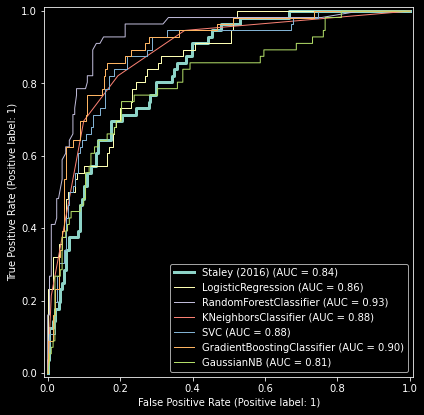

In [119]:
fig,ax=plt.subplots(figsize=(6,6))
fig.subplots_adjust(left=0.125, bottom=0.1, top=0.98, right=0.98)

def compare_rocs(models, ax):
    
    for modelkind in models.keys():
        if type(models[modelkind]).__name__ not in  ['Series','ndarray']:
            
            if type(models[modelkind]).__name__ in ['SVC', 'KNeighborsClassifier']:
                RocCurveDisplay.from_estimator(models[modelkind], testX_s, testY, ax=ax,
                                              linewidth=1)
            else:
                RocCurveDisplay.from_estimator(models[modelkind], testX, testY, ax=ax,
                                              linewidth=1)
        else:
            RocCurveDisplay.from_predictions(testY, models[modelkind], ax=ax, name=modelkind,
                                            linewidth=3)
                
    ax.set_aspect('equal')
    ax.set_xlim(-0.01, 1.01)
    ax.set_ylim(-0.01, 1.01)
    
compare_rocs(models, ax)
fig.savefig("roc_totaccum_addl_features_randn.png", dpi=300)

This code saves the predictions for each classifier into subdirectory.  These will be used to plot up ROC curves obtained using different features against each other:

In [120]:
from os.path import isdir
from posix import mkdir 

odir="newfeats_accum_randn"

if not isdir(odir):
    mkdir(odir)

In [121]:
import pickle

In [122]:
for key in models.keys():
    
    if type(models[key]).__name__ != 'ndarray':
        if type(models[key]).__name__ in ['SVC', 'KNeighborsClassifier']:
            testY_proba=models[key].predict_proba(testX_s)
        else:
            testY_proba=models[key].predict_proba(testX)
    else:
        testY_proba=models[key]
        
    outfile=odir + '/' + key + '_proba.pkl'
    pickle.dump(testY_proba, open(outfile, "wb"))

In [123]:
!ls -l $odir

total 60
-rw-r--r-- 1 droten droten 4265 May 19 21:21 'Gradient Boosting_proba.pkl'
-rw-r--r-- 1 droten droten 4265 May 19 21:21 'K-Nearest Neighbors_proba.pkl'
-rw-r--r-- 1 droten droten 4265 May 19 21:21 'Logistic Regression_proba.pkl'
-rw-r--r-- 1 droten droten 4265 May 19 21:21 'Naive Bayes_proba.pkl'
-rw-r--r-- 1 droten droten 4265 May 19 21:21 'Random Forest_proba.pkl'
-rw-r--r-- 1 droten droten 4265 May 19 21:21  SVC_proba.pkl
-rw-r--r-- 1 droten droten 2207 May 19 21:21 'Staley (2016)_proba.pkl'
-rw-r--r-- 1 droten droten 6924 May 19 20:58  testY.pkl


In [124]:
pickle.dump(testY, open(f"{odir}/testY.pkl", "wb"))

From [diagnostic test assessment](https://www.sciencedirect.com/science/article/pii/S1556086415306043):

"AUC is an effective way to summarize the overall diagnostic accuracy of the test. It takes values from 0 to 1, where a value of 0 indicates a perfectly inaccurate test and a value of 1 reflects a perfectly accurate test. AUC can be computed using the trapezoidal rule. In general, an AUC of 0.5 suggests no discrimination (i.e., ability to diagnose patients with and without the disease or condition based on the test), 0.7 to 0.8 is considered acceptable, 0.8 to 0.9 is considered excellent, and more than 0.9 is considered outstanding."

Merge training and testing data, and re-train:

In [125]:
traintestX = pd.concat([trainX, testX])
traintestY = pd.concat([trainY, testY])

traintestX.shape, traintestY.shape

((1241, 10), (1241,))

Save trained classifier.  It will be re-used for making predictions on new cases:

In [126]:
clffp = RandomForestClassifier(max_depth=rfdpt, random_state=0, criterion="gini")
clffp.fit(traintestX, traintestY)
pickle.dump(clffp, open("Random_forest_classifier_newfeats.pkl", "wb"))